In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

# ========================
# 2. Load the Data
# ========================

train = pd.read_csv("C:\\Users\\user\\OneDrive\\Desktop\\DS\\Project\\Train.csv")
test = pd.read_csv("C:\\Users\\user\\OneDrive\\Desktop\\DS\\Project\\Test.csv")

print("Train Shape:", train.shape)
train.head()

# ========================
# 3. Initial Data Cleaning
# ========================
drop_cols = [
    'Amount', 'batch ID', 'Currency', 'Country code', 'Provider ID',
    'Channel ID', 'Loan issued date', 'currency', 'Amount loan',
    'loan ID', 'loan application ID', 'Payback ID', 'ThirdPartyID',
    'IsThirdPartyConfirmed'
]

train.drop(columns=drop_cols, inplace=True, errors='ignore')
train.dropna(inplace=True)
train.reset_index(drop=True, inplace=True)


Train Shape: (2100, 27)


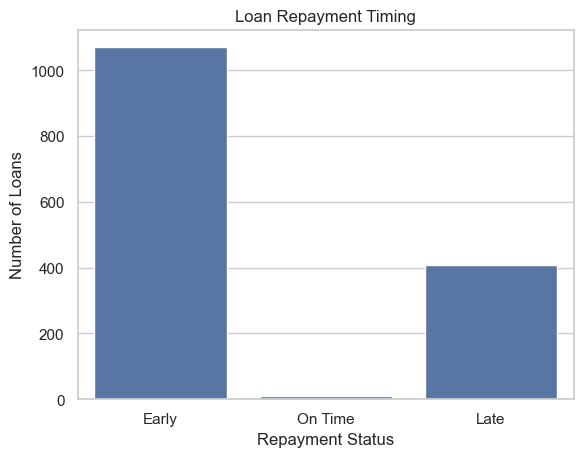

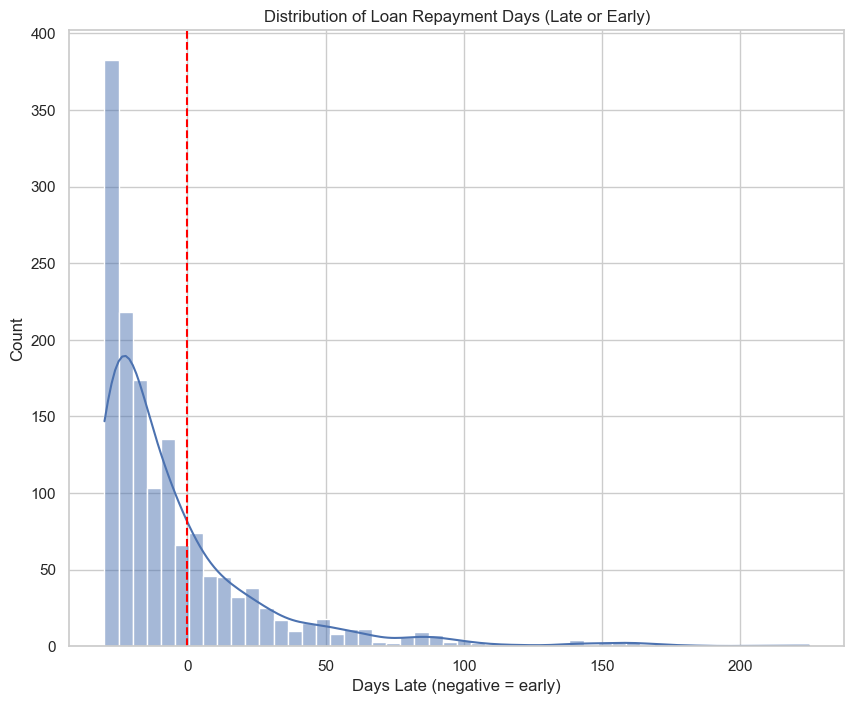

In [12]:
# ========================
# EDA: Loan Repayment vs Due Date
# ========================

# Load original data again if columns were dropped
full_train = pd.read_csv("C:\\Users\\user\\OneDrive\\Desktop\\DS\\Project\\Train.csv")

# Ensure both date columns exist
if 'PaidOnDate' in full_train.columns and 'DueDate' in full_train.columns:
    
    # Convert to datetime
    full_train['PaidOnDate'] = pd.to_datetime(full_train['PaidOnDate'], errors='coerce')
    full_train['DueDate'] = pd.to_datetime(full_train['DueDate'], errors='coerce')
    
    # Drop rows with invalid or missing dates
    full_train.dropna(subset=['PaidOnDate', 'DueDate'], inplace=True)

    # Calculate days early/late
    full_train['Days_Late'] = (full_train['PaidOnDate'] - full_train['DueDate']).dt.days

    # Add repayment status
    full_train['Repayment_Status'] = full_train['Days_Late'].apply(
        lambda x: 'On Time' if x == 0 else ('Late' if x > 0 else 'Early')
    )

    # Distribution of repayment status
    sns.countplot(x='Repayment_Status', data=full_train, order=['Early', 'On Time', 'Late'])
    plt.title('Loan Repayment Timing')
    plt.xlabel('Repayment Status')
    plt.ylabel('Number of Loans')
    plt.show()

    # Histogram of days late or early
    plt.figure(figsize=(10, 8))
    sns.histplot(full_train['Days_Late'], bins=50, kde=True)
    plt.axvline(0, color='red', linestyle='--')
    plt.title('Distribution of Loan Repayment Days (Late or Early)')
    plt.xlabel('Days Late (negative = early)')
    plt.ylabel('Count')
    plt.show()

    # Boxplot of lateness by Good_Bad_flag if available
    if 'Good_Bad_flag' in full_train.columns:
        plt.figure(figsize=(10, 8))
        sns.boxplot(x='Good_Bad_flag', y='Days_Late', data=full_train)
        plt.title('Days Late vs Good_Bad_flag')
        plt.show()
else:
    print("Required columns 'PaidOnDate' or 'DueDate' not found in the dataset.")


C:\Users\user\AppData\Local\Temp\ipykernel_6112\1661053828.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='IsDefaulted', data=train, palette=['mediumseagreen', 'salmon'])


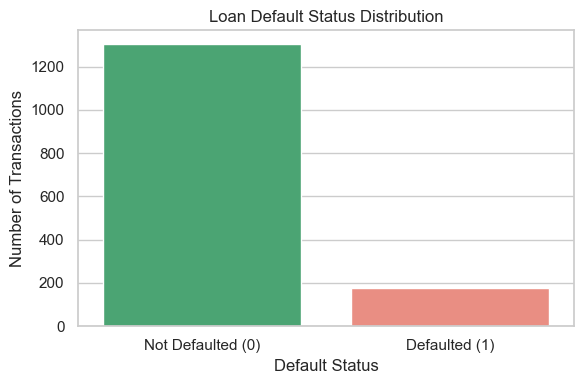

In [40]:
# Bar chart
plt.figure(figsize=(6, 4))
sns.countplot(x='IsDefaulted', data=train, palette=['mediumseagreen', 'salmon'])

# Labeling
plt.xticks([0, 1], ['Not Defaulted (0)', 'Defaulted (1)'])
plt.title('Loan Default Status Distribution')
plt.xlabel('Default Status')
plt.ylabel('Number of Transactions')
plt.tight_layout()
plt.show()

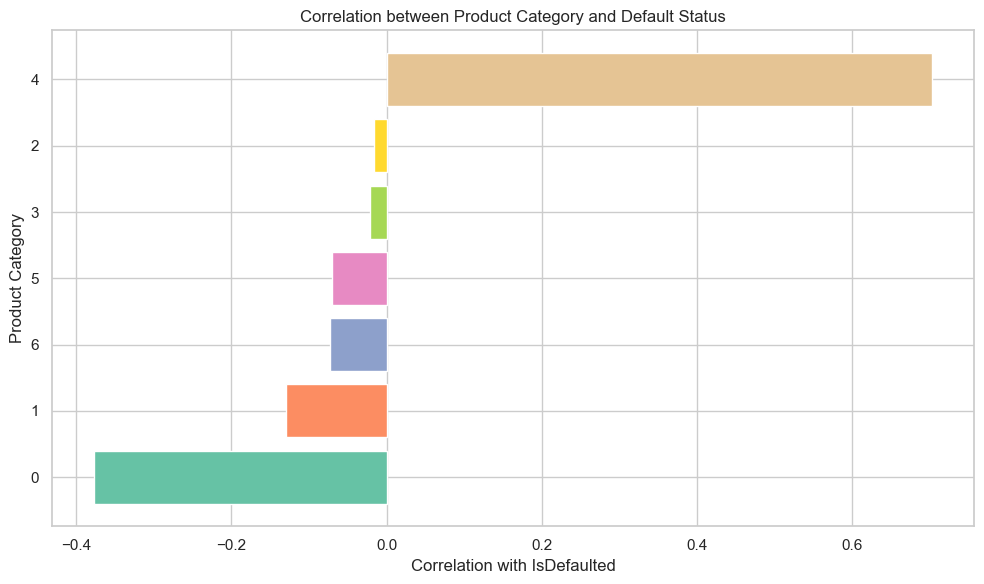

In [42]:
# Filter and clean relevant columns
df = train[['ProductCategory', 'IsDefaulted']].dropna()
df['IsDefaulted'] = pd.to_numeric(df['IsDefaulted'], errors='coerce').astype(int)

# One-hot encode ProductCategory
df_encoded = pd.get_dummies(df, columns=['ProductCategory'])

# Compute correlation
correlations = df_encoded.corr()['IsDefaulted'].drop('IsDefaulted').sort_values()

# Get unique color for each bar
category_names = correlations.index.str.replace('ProductCategory_', '')
num_categories = len(category_names)
colors = sns.color_palette('Set2', n_colors=num_categories)

# Plot bar chart with different colors
plt.figure(figsize=(10, 6))
bars = plt.barh(category_names, correlations.values, color=colors)
plt.title('Correlation between Product Category and Default Status')
plt.xlabel('Correlation with IsDefaulted')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_6112\3240032677.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='IsDefaulted', y='Value', data=df, palette='Set2', inner='quartile')


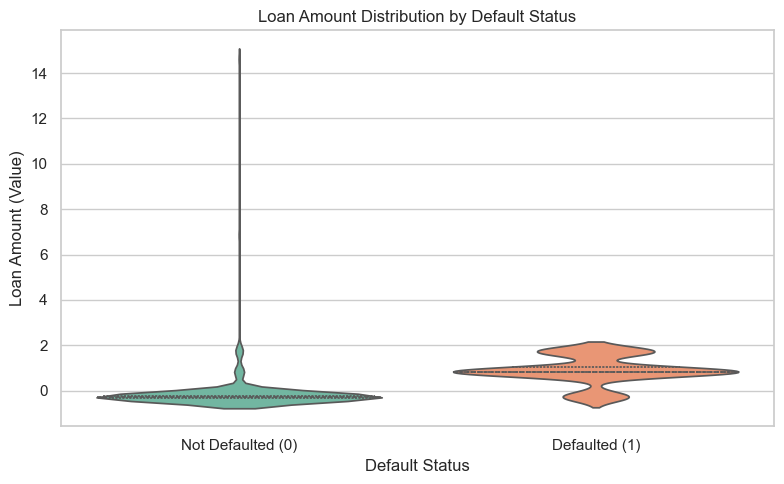

In [45]:
plt.figure(figsize=(8, 5))
sns.violinplot(x='IsDefaulted', y='Value', data=df, palette='Set2', inner='quartile')
plt.xticks([0, 1], ['Not Defaulted (0)', 'Defaulted (1)'])
plt.title('Loan Amount Distribution by Default Status')
plt.xlabel('Default Status')
plt.ylabel('Loan Amount (Value)')
plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_6112\3146916671.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='IsDefaulted', y='Value', data=value_summary, palette=['mediumseagreen', 'salmon'])


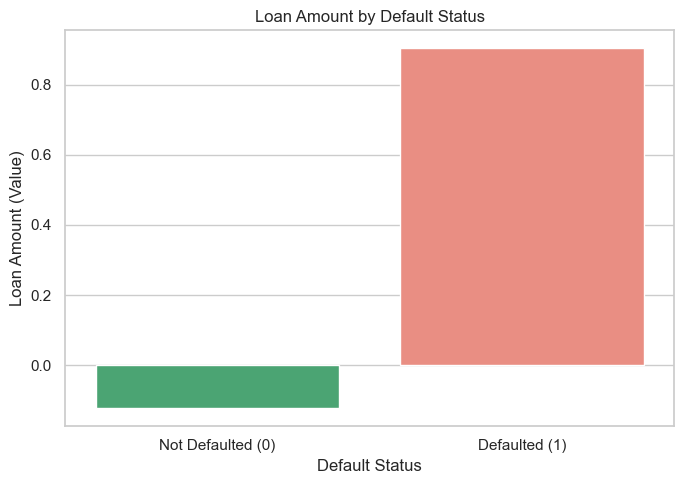

In [47]:
df = train[['Value', 'IsDefaulted']].dropna()
df['IsDefaulted'] = pd.to_numeric(df['IsDefaulted'], errors='coerce').astype(int)

# Group by IsDefaulted and compute average loan amount
value_summary = df.groupby('IsDefaulted')['Value'].mean().reset_index()

# Plot the bar chart
plt.figure(figsize=(7, 5))
sns.barplot(x='IsDefaulted', y='Value', data=value_summary, palette=['mediumseagreen', 'salmon'])

# Customize axis and labels
plt.xticks([0, 1], ['Not Defaulted (0)', 'Defaulted (1)'])
plt.title('Loan Amount by Default Status')
plt.xlabel('Default Status')
plt.ylabel('Loan Amount (Value)')
plt.tight_layout()
plt.show()

In [48]:
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = train.select_dtypes(include=['object']).columns.tolist()

target = 'Good_Bad_flag'
if target in num_cols:
    num_cols.remove(target)

le = LabelEncoder()
for col in cat_cols:
    train[col] = le.fit_transform(train[col])

scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])